In this notebook, we'll create a simple model using the Keras API to filter tracks from the SHMS dataset. Work on these tutorials has been supported in part by the Department of Energy Office of Nuclear Physics through EIC Detector R&D project eRD20.

# Initialization

In [1]:
import uproot  # ROOT file manipulator

# Standard data science imports
import numpy as np
import matplotlib.pyplot as plt

# Keras API imports
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.models import Sequential, Model, load_model
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.layers import Input, Dense, Dropout
from tensorflow.python.keras import backend as K

# Custom helper library imports
from lib.pdc import particle_drift_chamber as PDC  # this class contains the geometry data from the detectors
import lib.shms_helpers as shms

In [2]:
# Enable interractive plots
%matplotlib notebook

In [3]:
# Open ROOT file
file = uproot.open('/volatile/hallc/comm2017/mkjones/ROOTfiles/shms_coin_replay_production_all_4019_100000.root')
tree = file['T']

# Set data key prefixes so we don't have to type them every time
g = 'P.dc.gtrack.'
h = 'P.dc.hits.'

# Data location
keras_model_loc = 'data/trained_models/shms_keras_model_ffnnfilterbothpdc.h5'

# Data Processing
As usual, we reshape the data. If you did your homework in the previous notebooks, you should have noticed that some of the tracks in the `P.dc.hits` arrays were completely empty. We remove those because they are trivial to filter and do not add any useful information for training our machine learning model.

In [4]:
# Collate parallel TBranch objects
h_tracks = shms.collate(tree[h + 'plane'], tree[h + 'time'], tree[h + 'wirenum'], validate=False)
g_tracks = shms.collate(tree[g + 'plane'], tree[g + 'time'], tree[g + 'wirenum'], validate=False)

# Remove completely empty tracks
g_tracks = [track for i, track in enumerate(g_tracks) if len(h_tracks[i]) > 0]
print('Data contained', len(h_tracks) - len(g_tracks), 'empty tracks')
h_tracks = [track for track in h_tracks if len(track) > 0]

Data contained 6770 empty tracks


To represent our data, we will use [one-hot encoding](https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/). This means that for each plane, we mark wires with a 1 or a 0 depending on whether that wire detected a particle. The helper library contains a function to do this for all the tracks in the dataset.

In [5]:
# Create one-hot encoded vectors for each track
h_tracks_onehot = shms.tracks_to_onehot(h_tracks, padx=False, concat=True)
g_tracks_onehot = shms.tracks_to_onehot(g_tracks, padx=False, concat=False)

# Split g_tracks data up by plane
g_tracks_onehot_1u1 = np.array([track[0] for track in g_tracks_onehot])
g_tracks_onehot_1u2 = np.array([track[1] for track in g_tracks_onehot])
g_tracks_onehot_1x1 = np.array([track[2] for track in g_tracks_onehot])
g_tracks_onehot_1x2 = np.array([track[3] for track in g_tracks_onehot])
g_tracks_onehot_1v1 = np.array([track[4] for track in g_tracks_onehot])
g_tracks_onehot_1v2 = np.array([track[5] for track in g_tracks_onehot])
g_tracks_onehot_2v2 = np.array([track[6] for track in g_tracks_onehot])
g_tracks_onehot_2v1 = np.array([track[7] for track in g_tracks_onehot])
g_tracks_onehot_2x2 = np.array([track[8] for track in g_tracks_onehot])
g_tracks_onehot_2x1 = np.array([track[9] for track in g_tracks_onehot])
g_tracks_onehot_2u2 = np.array([track[10] for track in g_tracks_onehot])
g_tracks_onehot_2u1 = np.array([track[11] for track in g_tracks_onehot])

# Calculate a flag for each track to indicate whether it was accepted or rejected by gtrack
g_tracks_accepted = np.array([1 if len(track) > 0 else 0 for track in g_tracks])
g_tracks_accepted = np.stack((g_tracks_accepted, 1 - g_tracks_accepted), axis=1)

In [6]:
t = 1

print(    len(g_tracks_onehot_1u1[t]), np.argmax(g_tracks_onehot_1u1[t]))
print(    len(g_tracks_onehot_1u2[t]), np.argmax(g_tracks_onehot_1u2[t]))
print('', len(g_tracks_onehot_1x1[t]), np.argmax(g_tracks_onehot_1x1[t]))
print('', len(g_tracks_onehot_1x2[t]), np.argmax(g_tracks_onehot_1x2[t]))
print(    len(g_tracks_onehot_1v1[t]), np.argmax(g_tracks_onehot_1v1[t]))
print(    len(g_tracks_onehot_1v2[t]), np.argmax(g_tracks_onehot_1v2[t]))
print(    len(g_tracks_onehot_2v2[t]), np.argmax(g_tracks_onehot_2v2[t]))
print(    len(g_tracks_onehot_2v1[t]), np.argmax(g_tracks_onehot_2v1[t]))
print('', len(g_tracks_onehot_2x2[t]), np.argmax(g_tracks_onehot_2x2[t]))
print('', len(g_tracks_onehot_2x1[t]), np.argmax(g_tracks_onehot_2x1[t]))
print(    len(g_tracks_onehot_2u2[t]), np.argmax(g_tracks_onehot_2u2[t]))
print(    len(g_tracks_onehot_2u1[t]), np.argmax(g_tracks_onehot_2u1[t]))
print(g_tracks_accepted[t])

107 0
107 0
 79 0
 79 0
107 0
107 0
107 0
107 0
 79 0
 79 0
107 0
107 0
[0 1]


# Construct Keras Model
For this example, we want to have one softmax ouptut for each wire plane. We use the [Keras Functional API](https://keras.io/getting-started/functional-api-guide/) to be able to use multiple outputs.

In [7]:
# Define constants
input_features = sum(PDC.num_wires)

train_split = 0.9  # percentage of data to use when training (the rest is used when testing)
train_split_idx = round(len(h_tracks_onehot) * train_split)

In [8]:
# Build model using the Functional API
inputs = Input(shape=(input_features,))

net = inputs

# Hidden layer
net = Dense(256, activation='relu')(net)
net = Dropout(0.2)(net)
net = Dense(256, activation='relu')(net)
net = Dropout(0.2)(net)

# One softmax output for each wire plane
output_1u1 = Dense(PDC.num_wires[0], activation='softmax')(net)
output_1u2 = Dense(PDC.num_wires[1], activation='softmax')(net)
output_1x1 = Dense(PDC.num_wires[2], activation='softmax')(net)
output_1x2 = Dense(PDC.num_wires[3], activation='softmax')(net)
output_1v1 = Dense(PDC.num_wires[4], activation='softmax')(net)
output_1v2 = Dense(PDC.num_wires[5], activation='softmax')(net)
output_2v2 = Dense(PDC.num_wires[6], activation='softmax')(net)
output_2v1 = Dense(PDC.num_wires[7], activation='softmax')(net)
output_2x2 = Dense(PDC.num_wires[8], activation='softmax')(net)
output_2x1 = Dense(PDC.num_wires[9], activation='softmax')(net)
output_2u2 = Dense(PDC.num_wires[10], activation='softmax')(net)
output_2u1 = Dense(PDC.num_wires[11], activation='softmax')(net)

# ...And one for the accepted/rejected flag
net = Dense(16, activation='relu')(net)
output_accepted = Dense(2, activation='softmax')(net)

outputs = [output_1u1, output_1u2, output_1x1, output_1x2, output_1v1, output_1v2,
           output_2v2, output_2v1, output_2x2, output_2x1, output_2u2, output_2u1,
           output_accepted]

model = Model(inputs=inputs, outputs=outputs)

In [9]:
model.compile(
    optimizer=Adam(lr=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']#, 'mse', 'mae', 'binary_accuracy',
    #         'categorical_accuracy', 'sparse_categorical_accuracy',
    #         'top_k_categorical_accuracy', 'sparse_top_k_categorical_accuracy']
)

In [10]:
model.summary()

In [11]:
# Shuffle arrays
(h_tracks_onehot,
 g_tracks_onehot_1u1, g_tracks_onehot_1u2,
 g_tracks_onehot_1x1, g_tracks_onehot_1x2,
 g_tracks_onehot_1v1, g_tracks_onehot_1v2,
 g_tracks_onehot_2v2, g_tracks_onehot_2v1,
 g_tracks_onehot_2x2, g_tracks_onehot_2x1,
 g_tracks_onehot_2u2, g_tracks_onehot_2u1,
 g_tracks_accepted) = \
        shms.unison_shuffle((
            h_tracks_onehot,
            g_tracks_onehot_1u1, g_tracks_onehot_1u2,
            g_tracks_onehot_1x1, g_tracks_onehot_1x2,
            g_tracks_onehot_1v1, g_tracks_onehot_1v2,
            g_tracks_onehot_2v2, g_tracks_onehot_2v1,
            g_tracks_onehot_2x2, g_tracks_onehot_2x1,
            g_tracks_onehot_2u2, g_tracks_onehot_2u1,
            g_tracks_accepted
        ))

In [ ]:
model.fit(
    x=h_tracks_onehot[:train_split_idx],
    y=[g_tracks_onehot_1u1[:train_split_idx], g_tracks_onehot_1u2[:train_split_idx],
       g_tracks_onehot_1x1[:train_split_idx], g_tracks_onehot_1x2[:train_split_idx],
       g_tracks_onehot_1v1[:train_split_idx], g_tracks_onehot_1v2[:train_split_idx],
       g_tracks_onehot_2v2[:train_split_idx], g_tracks_onehot_2v1[:train_split_idx],
       g_tracks_onehot_2x2[:train_split_idx], g_tracks_onehot_2x1[:train_split_idx],
       g_tracks_onehot_2u2[:train_split_idx], g_tracks_onehot_2u1[:train_split_idx],
       g_tracks_accepted[:train_split_idx]],
    epochs=100,
    batch_size=128,
    shuffle=True,
    verbose=1
)

In [26]:
# Save trained model
model.save(keras_model_loc)
print('Successfully saved model to: "' + keras_model_loc + '"')

Successfully saved model to: "data/trained_models/shms_keras_model_ffnnfilterbothpdc.h5"


In [14]:
result = model.evaluate(
    x=h_tracks_onehot[:train_split_idx],
    y=[g_tracks_onehot_1u1[:train_split_idx], g_tracks_onehot_1u2[:train_split_idx],
       g_tracks_onehot_1x1[:train_split_idx], g_tracks_onehot_1x2[:train_split_idx],
       g_tracks_onehot_1v1[:train_split_idx], g_tracks_onehot_1v2[:train_split_idx],
       g_tracks_onehot_2v2[:train_split_idx], g_tracks_onehot_2v1[:train_split_idx],
       g_tracks_onehot_2x2[:train_split_idx], g_tracks_onehot_2x1[:train_split_idx],
       g_tracks_onehot_2u2[:train_split_idx], g_tracks_onehot_2u1[:train_split_idx],
       g_tracks_accepted[:train_split_idx]]
)
for name, value in zip(model.metrics_names[:14], result[:14]):
    print(name, round(value, 4))

result = model.evaluate(
    x=h_tracks_onehot[train_split_idx:],
    y=[g_tracks_onehot_1u1[train_split_idx:], g_tracks_onehot_1u2[train_split_idx:],
       g_tracks_onehot_1x1[train_split_idx:], g_tracks_onehot_1x2[train_split_idx:],
       g_tracks_onehot_1v1[train_split_idx:], g_tracks_onehot_1v2[train_split_idx:],
       g_tracks_onehot_2v2[train_split_idx:], g_tracks_onehot_2v1[train_split_idx:],
       g_tracks_onehot_2x2[train_split_idx:], g_tracks_onehot_2x1[train_split_idx:],
       g_tracks_onehot_2u2[train_split_idx:], g_tracks_onehot_2u1[train_split_idx:],
       g_tracks_accepted[train_split_idx:]]
)
for name, value in zip(model.metrics_names[:14], result[:14]):
    print(name, round(value, 4))

70429/70429 [==============================] - 9s 127us/step
loss 0.3127
dense_3_loss 0.0121
dense_4_loss 0.0107
dense_5_loss 0.0087
dense_6_loss 0.0092
dense_7_loss 0.0104
dense_8_loss 0.0104
dense_9_loss 0.0094
dense_10_loss 0.008
dense_11_loss 0.0087
dense_12_loss 0.0092
dense_13_loss 0.0098
dense_14_loss 0.0095
dense_16_loss 0.1964
7825/7825 [==============================] - 1s 127us/step
loss 1.9021
dense_3_loss 0.1566
dense_4_loss 0.1579
dense_5_loss 0.1561
dense_6_loss 0.1551
dense_7_loss 0.1388
dense_8_loss 0.1393
dense_9_loss 0.1065
dense_10_loss 0.1025
dense_11_loss 0.1218
dense_12_loss 0.1245
dense_13_loss 0.1212
dense_14_loss 0.1275
dense_16_loss 0.2942


# Results Visualization

In [ ]:
# Un-shuffle arrays
h_tracks_onehot = shms.tracks_to_onehot(h_tracks, padx=False, concat=True)
#g_tracks_onehot = shms.tracks_to_onehot(g_tracks, padx=False, concat=False)

g_tracks_onehot_1u1 = np.asarray([track[0] for track in g_tracks_onehot])
g_tracks_onehot_1u2 = np.asarray([track[1] for track in g_tracks_onehot])
g_tracks_onehot_1x1 = np.asarray([track[2] for track in g_tracks_onehot])
g_tracks_onehot_1x2 = np.asarray([track[3] for track in g_tracks_onehot])
g_tracks_onehot_1v1 = np.asarray([track[4] for track in g_tracks_onehot])
g_tracks_onehot_1v2 = np.asarray([track[5] for track in g_tracks_onehot])
g_tracks_onehot_2v2 = np.asarray([track[6] for track in g_tracks_onehot])
g_tracks_onehot_2v1 = np.asarray([track[7] for track in g_tracks_onehot])
g_tracks_onehot_2x2 = np.asarray([track[8] for track in g_tracks_onehot])
g_tracks_onehot_2x1 = np.asarray([track[9] for track in g_tracks_onehot])
g_tracks_onehot_2u2 = np.asarray([track[10] for track in g_tracks_onehot])
g_tracks_onehot_2u1 = np.asarray([track[11] for track in g_tracks_onehot])

g_tracks_accepted = np.array([1 if len(track) > 0 else 0 for track in g_tracks])

In [ ]:
# Load pre-trained model
#model = load_model(keras_model_loc)

<IPython.core.display.Javascript object>


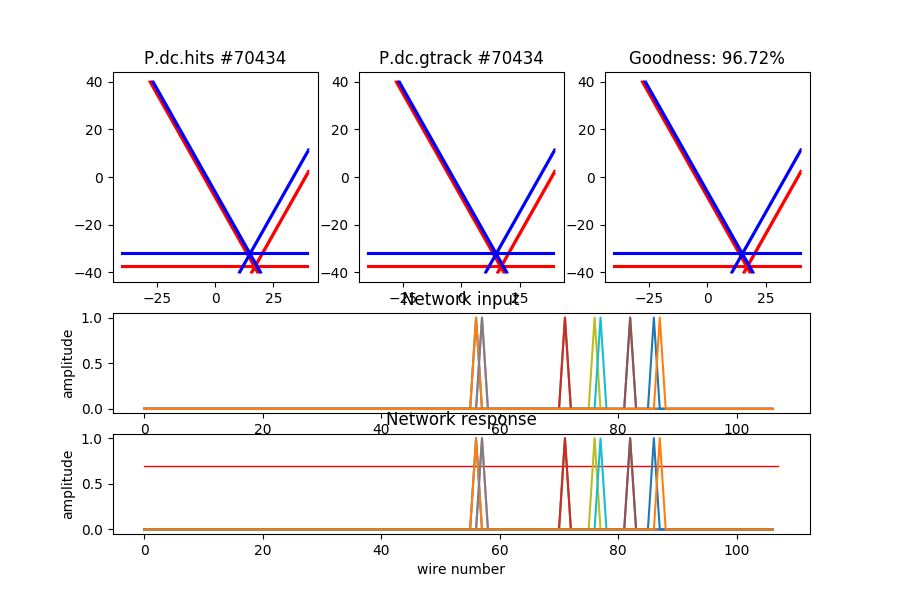

In [25]:
#t = train_split_idx + 0
threshold = 0.7
goodness_cutoff = 0.6

fig_dim = 3
fig = plt.figure( figsize=(3 * fig_dim, 2 * fig_dim) )

ax1 = plt.subplot(231)
plt.title(h[:-1] + ' #' + str(t))
#plt.xticks([])
#plt.yticks([])
for hit in [hit for hit in h_tracks[t] if hit[0] > 6]:
    line = shms.hit_to_2d(hit)
    plt.plot(line[0], line[1], 'r')
for hit in [hit for hit in h_tracks[t] if hit[0] < 7]:
    line = shms.hit_to_2d(hit)
    plt.plot(line[0], line[1], 'b')

ax2 = plt.subplot(232, sharex=ax1, sharey=ax1)  # sharex/sharey make subplots pan/zoom together
plt.title(g[:-1] + ' #' + str(t))
#plt.xticks([])
#plt.yticks([])
for hit in [hit for hit in g_tracks[t] if hit[0] > 6]:
    line = shms.hit_to_2d(hit)
    plt.plot(line[0], line[1], 'r')
for hit in [hit for hit in g_tracks[t] if hit[0] < 7]:
    line = shms.hit_to_2d(hit)
    plt.plot(line[0], line[1], 'b')

response = model.predict(h_tracks_onehot[t].reshape(1, input_features))
ax3 = plt.subplot(233, sharex=ax1, sharey=ax1)
plt.title('Goodness: {}%'.format(round(response[-1][0][0] * 100, 2)))
if response[-1][0][0] > goodness_cutoff:
    for plane in range(6, 12):
        for wirenum in range(PDC.num_wires[plane]):
            if response[plane][0][wirenum] > threshold:
                line = shms.hit_to_2d([plane+1, 0, wirenum+1])
                plt.plot(line[0], line[1], 'r')
    for plane in range(0, 6):
        for wirenum in range(PDC.num_wires[plane]):
            if response[plane][0][wirenum] > threshold:
                line = shms.hit_to_2d([plane+1, 0, wirenum+1])
                plt.plot(line[0], line[1], 'b')
"""
# Alternative method of reconstructing network output
for i in range(6, 12):
    plane = i + 1
    time = 0  # we can't reconstruct the drift time
    wirenum = np.argmax(response[i]) + 1
    if max(response[i][0]) > threshold:
        line = shms.hit_to_2d([plane, time, wirenum])
        plt.plot(line[0], line[1], 'r')
for i in range(0, 6):
    plane = i + 1
    time = 0  # we can't reconstruct the drift time
    wirenum = np.argmax(response[i]) + 1
    if max(response[i][0]) > threshold:
        line = shms.hit_to_2d([plane, time, wirenum])
        plt.plot(line[0], line[1], 'b')
"""

ax4 = plt.subplot(413)
plt.title('Network input')
#plt.xlabel('wire number')
plt.ylabel('amplitude')
#plt.xticks([])
legend_labels = ['1u1', '1u2', '1x1', '1x2', '1v1', '1v2',
                 '2v2', '2v1', '2x2', '2x1', '2u2', '2u1']
for i in range(11):
    plt.plot(h_tracks_onehot[t][sum(PDC.num_wires[:i]) : sum(PDC.num_wires[:i+1])],
             label=legend_labels[i])
plt.plot(h_tracks_onehot[t][sum(PDC.num_wires[:-1]) : sum(PDC.num_wires)],
         label=legend_labels[11])

ax3 = plt.subplot(414, sharex=ax4, sharey=ax4)
plt.title('Network response')
plt.xlabel('wire number')
plt.ylabel('amplitude')
plt.plot([0, max(PDC.num_wires)], [threshold, threshold],
         color='r', linewidth=1, label='threshold')  # mark threshold line
legend_labels = ['1u1', '1u2', '1x1', '1x2', '1v1', '1v2',
                 '2v2', '2v1', '2x2', '2x1', '2u2', '2u1']
for plane, label in zip(response, legend_labels):
    plt.plot(plane[0], label=label)  # each response is wrapped in an extraneous dimension for some reason
#plt.legend()

plt.show()